In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as tfs
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torchvision import models
from IPython.display import clear_output

import pandas as pd

from __future__ import print_function, division
import os

from skimage import io, transform

from tqdm.notebook import tqdm
from tqdm.autonotebook import trange
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
import time

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu') 
device


device(type='cuda', index=0)

---
### This notebook requires a GPU runtime to run.
### Please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"
---

Previous year there was a [good Computer Vision practice lesson](https://www.youtube.com/watch?v=XSPYe4-y4HE) (RUS), its [notebooks](https://drive.google.com/drive/folders/1ZpS8oyI__3QvjoIwVZwur4I5e4qIExPS?usp=sharing).

This year we will master inference and training of the SSD neural network discussed on the lecture.

This notebook is based on [NVIDIA deep learning examples](https://github.com/NVIDIA/DeepLearningExamples ). 

**[Cinematic NVIDIA keynotes](https://www.youtube.com/watch?v=CKnipnFsuFo&list=PLZHnYvH1qtOYOfzAj7JZFwqtabM5XPku1) on Deep Learning 2020.**




# SSD

*Author: NVIDIA*

**Single Shot MultiBox Detector model for object detection**

_ | _
- | -
![alt](https://pytorch.org/assets/images/ssd_diagram.png) | ![alt](https://pytorch.org/assets/images/ssd.png)

In [11]:
# =========================================
# ===========CHEK VIDEO INF AND INSTALL LIB ==============================
# =========================================

# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version
!nvidia-smi
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install -U openmim
!pip install mmcv-full

!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
!ls
%cd mmdetection
!ls
!pip install -v -e .


# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Thu Feb  9 12:02:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+==

In [4]:
!pip install jedi 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.4 MB/s eta 0:00:00


In [12]:

!mim install mmcv-full


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.5.0/index.html


In [6]:
print(torch.__version__, torch.cuda.is_available())

1.13.1+cu116 True


Cloning into 'mmdetection'...
remote: Enumerating objects: 33998, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 33998 (delta 34), reused 78 (delta 19), pack-reused 33868
Receiving objects: 100% (33998/33998), 45.55 MiB | 28.39 MiB/s, done.
Resolving deltas: 100% (23986/23986), done.
CITATION.cff  docs	   mmdetection	    README.md	      resources  tools
configs       LICENSE	   mmdet.egg-info   README_zh-CN.md   setup.cfg
demo	      MANIFEST.in  model-index.yml  requirements      setup.py
docker	      mmdet	   pytest.ini	    requirements.txt  tests
/content/mmdetection/mmdetection/mmdetection/mmdetection
CITATION.cff  docs	   model-index.yml  requirements      setup.py
configs       LICENSE	   pytest.ini	    requirements.txt  tests
demo	      MANIFEST.in  README.md	    resources	      tools
docker	      mmdet	   README_zh-CN.md  setup.cfg
Using pip 22.0.4 from /usr/local/lib/python3.8/dist-packages/pip (python 3.8)

In [13]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

import mmcv
print(mmcv.__version__)
!nvidia-smi
# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.13.1+cu116 True
2.28.1
1.7.1
Thu Feb  9 12:03:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                         

ImportError: ignored

## Perform inference with a MMDet detector
MMDetection already provides high level APIs to do inference and training.

Let's compare two models: Mask-RCNN (more heavy model) and SSD300 (more lightweight model).

Download the Mask-RCNN weights:

In [8]:
!mkdir checkpoints
# !wget -c https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
!wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2023-02-09 11:24:28--  https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.48.85.208, 8.48.85.210, 8.48.85.207, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.48.85.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/octet-stream]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  16.3MB/s    in 11s     

2023-02-09 11:24:39 (16.1 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



Download the SSD300 weights:

In [9]:
# !wget -c http://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20200307-a92d2092.pth \
!wget -c https://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20210803_015428-d231a06e.pth \
      -O checkpoints/ssd300_coco_20210803_015428-d231a06e.pth

!ls checkpoints

--2023-02-09 11:24:50--  https://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20210803_015428-d231a06e.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.48.85.208, 8.48.85.210, 8.48.85.207, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.48.85.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137242646 (131M) [application/octet-stream]
Saving to: ‘checkpoints/ssd300_coco_20210803_015428-d231a06e.pth’

checkpoints/ssd300_ 100%[===================>] 130.88M  16.8MB/s    in 8.0s    

2023-02-09 11:24:59 (16.3 MB/s) - ‘checkpoints/ssd300_coco_20210803_015428-d231a06e.pth’ saved [137242646/137242646]

mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
ssd300_coco_20210803_015428-d231a06e.pth


In [10]:
import mmdet
import mmdet.apis
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config_path = '/content/sample_data/mmdetection/configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'

# Setup a checkpoint file to load. Download the wegths 
checkpoint = '/content/sample_data/mmdetection/checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
# initialize the detector
model = init_detector(config_path, checkpoint, device='cuda:0')

ImportError: ignored

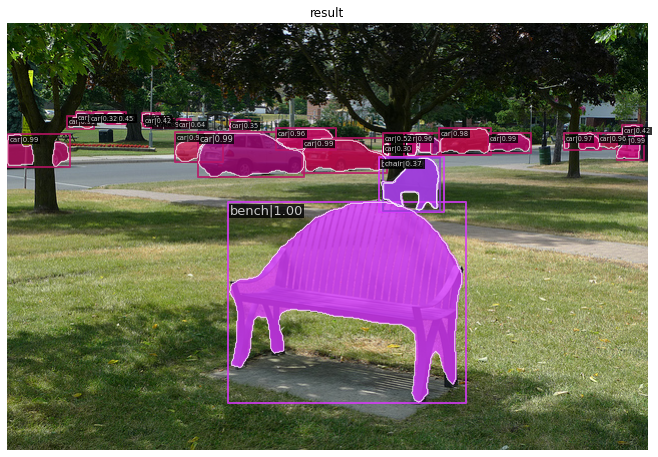

In [ ]:
# use the detector to do inference
img = "/content/sample_data/mmdetection/demo/demo.jpg"
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

load checkpoint from local path: /content/sample_data/mmdetection/checkpoints/ssd300_coco_20210803_015428-d231a06e.pth


/content/sample_data/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


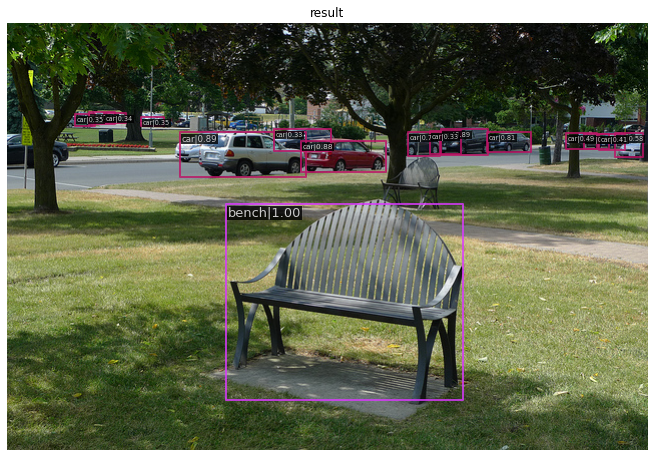

In [ ]:
config = "/content/sample_data/mmdetection/configs/ssd/ascend_ssd300_coco.py"
checkpoint = "/content/sample_data/mmdetection/checkpoints/ssd300_coco_20210803_015428-d231a06e.pth"
model = init_detector(config, checkpoint, device = device)
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

In [ ]:
!ls -la checkpoints

total 307740
drwxr-xr-x  2 root root      4096 Feb  8 09:42 .
drwxr-xr-x 17 root root      4096 Feb  8 09:42 ..
-rw-r--r--  1 root root 177867103 Nov  2  2021 mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
-rw-r--r--  1 root root 137242646 Nov  2  2021 ssd300_coco_20210803_015428-d231a06e.pth


## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector

### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. reorganize the dataset into COCO format.
  2. reorganize the dataset into a middle format.
  3. implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.

In this tutorial, we gives an example that converting the data into the format of existing datasets like COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/new_dataset.html#).

Firstly, let's download a tiny dataset obtained from [KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d). We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but has 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of dataset.

In [ ]:
# download, decompress the data
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null


# Check the directory structure of the tiny data
# Install tree first
!apt-get -q install tree
!tree kitti_tiny

--2023-02-08 10:21:44--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 8.48.85.214, 8.48.85.209, 8.48.85.208, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.48.85.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  8.64MB/s    in 0.8s    

2023-02-08 10:21:48 (8.64 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 28 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 

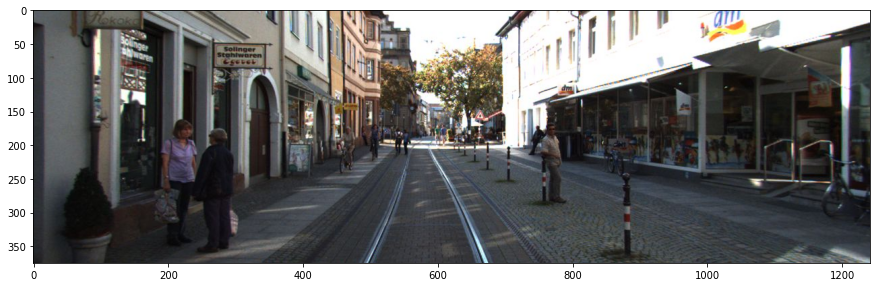

In [ ]:
import mmcv
img = mmcv.imread("/content/sample_data/mmdetection/kitti_tiny/training/image_2/000073.jpeg")
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()



In [ ]:
!cat kitti_tiny/training/label_2/000073.txt

Pedestrian 0.00 0 -2.62 237.23 173.70 312.33 365.33 1.58 0.66 0.53 -2.99 1.60 6.32 -3.05
Pedestrian 0.00 1 0.80 189.46 158.23 256.19 356.44 1.70 0.61 0.51 -3.62 1.58 6.54 0.31
Pedestrian 0.00 0 0.45 752.95 164.08 791.19 288.78 1.75 0.63 0.51 2.28 1.63 10.51 0.65
Cyclist 0.00 0 1.78 444.66 170.48 485.70 241.86 1.64 0.57 2.00 -3.55 1.60 17.61 1.58
Cyclist 0.00 0 1.65 494.34 168.08 517.01 223.73 1.80 0.60 1.85 -3.54 1.66 24.31 1.51
Pedestrian 0.00 0 -2.07 546.73 177.07 560.52 214.88 1.53 0.61 0.73 -2.41 1.71 29.83 -2.15
Pedestrian 0.00 0 -2.02 535.68 174.41 549.63 214.38 1.61 0.54 0.87 -2.86 1.68 29.55 -2.12
DontCare -1 -1 -10 596.02 166.69 615.85 203.19 -1 -1 -1 -1000 -1000 -1000 -10


According to the KITTI's documentation, the first column indicates the class of the object, and the 5th to 8th columns indicates the bboxes. We need to read annotations of each image and convert them into middle format MMDetection accept is as below:

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray> (n, 4),
            'labels': <np.ndarray> (n, ),
            'bboxes_ignore': <np.ndarray> (k, 4), (optional field)
            'labels_ignore': <np.ndarray> (k, 4) (optional field)
        }
    },
    ...
]
```

In [ ]:
import copy
import os.path as osp

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

In [ ]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

# ==============================================
# we need transform our kitty_data towards coco-shape data
# ==============================================

@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        # nu,ber of classes and its name
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            # remember name of pickture
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            
            # size of pickture
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []  #list of bounding boxes
            gt_labels = []  # list of labels
            gt_bboxes_ignore = [] #
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [ ]:
from mmcv import Config
model_type = "ssd"
if model_type == "ssd":
    cfg = Config.fromfile("/content/sample_data/mmdetection/configs/ssd/ssd300_coco.py")
elif model_type == "mask_rcnn":
    cfg = Config.fromfile("/content/sample_data/mmdetection/configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_1x_coco.py")

cfg["data"]



{'samples_per_gpu': 8,
 'workers_per_gpu': 3,
 'train': {'type': 'RepeatDataset',
  'times': 5,
  'dataset': {'type': 'CocoDataset',
   'ann_file': 'data/coco/annotations/instances_train2017.json',
   'img_prefix': 'data/coco/train2017/',
   'pipeline': [{'type': 'LoadImageFromFile'},
    {'type': 'LoadAnnotations', 'with_bbox': True},
    {'type': 'Expand',
     'mean': [123.675, 116.28, 103.53],
     'to_rgb': True,
     'ratio_range': (1, 4)},
    {'type': 'MinIoURandomCrop',
     'min_ious': (0.1, 0.3, 0.5, 0.7, 0.9),
     'min_crop_size': 0.3},
    {'type': 'Resize', 'img_scale': (300, 300), 'keep_ratio': False},
    {'type': 'RandomFlip', 'flip_ratio': 0.5},
    {'type': 'PhotoMetricDistortion',
     'brightness_delta': 32,
     'contrast_range': (0.5, 1.5),
     'saturation_range': (0.5, 1.5),
     'hue_delta': 18},
    {'type': 'Normalize',
     'mean': [123.675, 116.28, 103.53],
     'std': [1, 1, 1],
     'to_rgb': True},
    {'type': 'DefaultFormatBundle'},
    {'type': 'Col

In [ ]:
cfg

Config (path: /content/sample_data/mmdetection/configs/ssd/ssd300_coco.py): {'input_size': 300, 'model': {'type': 'SingleStageDetector', 'backbone': {'type': 'SSDVGG', 'depth': 16, 'with_last_pool': False, 'ceil_mode': True, 'out_indices': (3, 4), 'out_feature_indices': (22, 34), 'init_cfg': {'type': 'Pretrained', 'checkpoint': 'open-mmlab://vgg16_caffe'}}, 'neck': {'type': 'SSDNeck', 'in_channels': (512, 1024), 'out_channels': (512, 1024, 512, 256, 256, 256), 'level_strides': (2, 2, 1, 1), 'level_paddings': (1, 1, 0, 0), 'l2_norm_scale': 20}, 'bbox_head': {'type': 'SSDHead', 'in_channels': (512, 1024, 512, 256, 256, 256), 'num_classes': 80, 'anchor_generator': {'type': 'SSDAnchorGenerator', 'scale_major': False, 'input_size': 300, 'basesize_ratio_range': (0.15, 0.9), 'strides': [8, 16, 32, 64, 100, 300], 'ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]]}, 'bbox_coder': {'type': 'DeltaXYWHBBoxCoder', 'target_means': [0.0, 0.0, 0.0, 0.0], 'target_stds': [0.1, 0.1, 0.2, 0.2]}}, 'train_cf

In [ ]:
from mmdet.apis import set_random_seed

# =======================
# in priveosly block we download the config
# and now we need change its blocks for kitty dataset
# =======================

# ==============================================
# first of all we need to change all directories for
#                                                     test dataset
#                                                     val dataset
#                                                     train dataset
# ==============================================

# modify type and path:
cfg.dataset_type = "KittiTinyDataset"
cfg.data_root = "/content/sample_data/mmdetection/kitti_tiny/"

cfg.data.test.type = "KittiTinyDataset"
cfg.data.test.data_root = "/content/sample_data/mmdetection/kitti_tiny/"
cfg.data.test.ann_file = "/content/sample_data/mmdetection/kitti_tiny/train.txt"
cfg.data.test.img_prefix = "/content/sample_data/mmdetection/kitti_tiny/training/image_2"


if model_type == "ssd":
  cfg.data.train.dataset.type = 'KittiTinyDataset'
  cfg.data.train.dataset.data_root = '/content/sample_data/mmdetection/kitti_tiny/'
  cfg.data.train.dataset.ann_file = '/content/sample_data/mmdetection/kitti_tiny/train.txt'
  cfg.data.train.dataset.img_prefix = '/content/sample_data/mmdetection/kitti_tiny/training/image_2'
elif model_type == "mask_rcnn":
  cfg.data.train.type = 'KittiTinyDataset'
  cfg.data.train.data_root = '/content/sample_data/mmdetection/kitti_tiny/'
  cfg.data.train.ann_file = '/content/sample_data/mmdetection/kitti_tiny/train.txt'
  cfg.data.train.img_prefix = '/content/sample_data/mmdetection/kitti_tiny/training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = '/content/sample_data/mmdetection/kitti_tiny/'
cfg.data.val.ann_file = '/content/sample_data/mmdetection/kitti_tiny/val.txt'
cfg.data.val.img_prefix = '/content/sample_data/mmdetection/kitti_tiny/training/image_2'


#checkpoint = "/content/sample_data/mmdetection/checkpoints/ssd300_coco_20210803_015428-d231a06e.pth"
if model_type == "ssd":
  cfg.model.bbox_head.num_classes = 3
  cfg.load_from = '/content/sample_data/mmdetection/checkpoints/ssd300_coco_20210803_015428-d231a06e.pth'
elif model_type == "mask_rcnn":
  cfg.model.roi_head.bbox_head.num_classes = 3
  cfg.load_from = '/content/sample_data/mmdetection/checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/sample_data'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# ssd300_coco and ssd300_voc with 4gpu, 24 imgs per gpu and lr of 3e-3
cfg.optimizer.lr = 0.02 / 8.  # 3e-3
# cfg.lr_config.warmup = None
cfg.lr_config.policy = 'step'
cfg.lr_config.warmup = 'linear'
cfg.lr_config.warmup_ratio = 1.0 / 1e10

cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
input_size = 300
model = dict(
    type='SingleStageDetector',
    backbone=dict(
        type='SSDVGG',
        depth=16,
        with_last_pool=False,
        ceil_mode=True,
        out_indices=(3, 4),
        out_feature_indices=(22, 34),
        init_cfg=dict(
            type='Pretrained', checkpoint='open-mmlab://vgg16_caffe')),
    neck=dict(
        type='SSDNeck',
        in_channels=(512, 1024),
        out_channels=(512, 1024, 512, 256, 256, 256),
        level_strides=(2, 2, 1, 1),
        level_paddings=(1, 1, 0, 0),
        l2_norm_scale=20),
    bbox_head=dict(
        type='SSDHead',
        in_channels=(512, 1024, 512, 256, 256, 256),
        num_classes=3,
        anchor_generator=dict(
            type='SSDAnchorGenerator',
            scale_major=False,
            input_size=300,
            basesize_ratio_range=(0.15, 0.9),
            strides=[8, 16, 32, 64, 100, 300],
            ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]]),
        bbox_coder=dict(


In the previous block the errors probably will appears. This link can help us


> - [SSD training issue 1](https://github.com/open-mmlab/mmdetection/issues/1203)
- [SSD training issue 2](https://github.com/open-mmlab/mmdetection/issues/2448)


### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# build dataset
datasets = [build_dataset(cfg.data.train)]

# build detector/model

# model = build_dp(model, device_ids=cfg.gpu_ids) 
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# set classes in model
model.CLASSES = datasets[0].CLASSES

# create working directory
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=True, validate=True)

ModuleNotFoundError: ignored

- Andrej Karpathy (Tesla AI director) [keynote on multi-task learning](https://slideslive.com/38917690/multitask-learning-in-the-wilderness) (ENG)
- [CV practice 2019](https://www.youtube.com/watch?v=XSPYe4-y4HE) (RUS)
- [Habrahabr post: Classification & Representation](https://habr.com/ru/company/mipt/blog/458190/) (RUS)
- [Habrahabr post: Detection & Tracking](https://habr.com/ru/company/mipt/blog/450732/) (RUS)
